In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['font.sans-serif'] = "Calibri"
# mpl.rcParams['font.size'] = 6
plt.rc('font',family='Arial',size=8)
# Setting mathfont-------------------------------------
from matplotlib import rcParams
config = {"mathtext.fontset":'stix',}
rcParams.update(config)
# -----------------------------------------------------
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.patches as patches
import os
import math 
from scipy import ndimage
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator 
import matplotlib.dates as mdates
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
from pylab import *
import time
import datetime
from scipy import interpolate
import metpy.calc as mpcalc
from metpy.units import units
from skimage import transform
from scipy.stats.mstats import ttest_ind
import cmaps 
plt.close() 

In [ ]:
'''
------------------------------------------------
Read geopotential data
------------------------------------------------
'''

### Read the data ranging from 1979to2022 ###
# input_files = [f'/data1/other_data/DataUpdate/ERA5/new-era5/hourly/multiple/geopotential/geopotential_{year}12{str(day).zfill(2)}.nc' for year in range(1979,2023,1) for day in np.arange(1,32,1)]
# ds = xr.open_mfdataset(input_files)
# Z500_UTC00_1979to2022 = ds['z'].sel(time=ds['time.hour'].isin([0]), level=500).compute()
# Z500_UTC00_1979to2022.to_netcdf('../data/era5_pressure-level/geopotential/geopotential_UTC00_Dec_1979to2022.nc')
ds = xr.open_dataset('../data/era5_pressure-level/geopotential/geopotential_UTC00_Dec_1979to2022.nc')
Z500_UTC00_1979to2022 = ds['z']

ds2 = xr.open_dataset('../data/era5_2023_NovDec/Multiple_level/2023_NovDec_geopotential.nc')
Z500_UTC00_2023 = ds2['z'].sel(time=(ds2['time.hour'].isin([0])&ds2['time.month'].isin([12])), level=500)
Z500_UTC00_1979to2023 = xr.concat([Z500_UTC00_1979to2022,Z500_UTC00_2023], dim='time')

Z500_UTC00_clim = xr.DataArray(np.reshape(Z500_UTC00_1979to2023.values, (45,31,181,360)).mean(axis=0),
                                dims = ['time', 'latitude', 'longitude'],
                                coords = [Z500_UTC00_1979to2023['time'][:31], Z500_UTC00_1979to2023['latitude'], Z500_UTC00_1979to2023['longitude']])
Z500_ano_UTC00_2023 = Z500_UTC00_2023 - Z500_UTC00_clim.values

In [ ]:
'''
------------------------------------------------
Calculate PVy anomaly
------------------------------------------------
'''

import metpy
from datetime import datetime, timedelta

# # 起始日期和结束日期
# start_date = datetime(2024, 11, 1)
# end_date = datetime(2024, 12, 31)
# # 生成日期字符串
# dates = []
# current_date = start_date
# while current_date <= end_date:
#     dates.append(current_date.strftime("%m%d"))  # 格式为 MMDD
#     current_date += timedelta(days=1)
# input_files = [f'/data1/other_data/DataUpdate/ERA5/new-era5/daily/multiple/uwind/u_component_of_wind_{year}{date}.nc' for year in range(1979,2023,1) for date in dates]
# ds = xr.open_mfdataset(input_files)
# u500 = ds['u'].sel(level=500).compute()
# u500.to_netcdf('../data/era5_pressure-level/u500_daily-mean_NovDec_1979to2022.nc')
ds = xr.open_dataset('../data/era5_pressure-level/u500_daily-mean_NovDec_1979to2022.nc')
u500 = ds['u']

ds = xr.open_dataset('../data/era5_2023_NovDec/Multiple_level_daily/2023_NovDec_u_component_of_wind_daily.nc')
u500_1979to2023_NovDec = xr.concat([u500, ds['u'].sel(level=500)], dim='time')


###
### Calculate the non-dimensional PVy
###
beta = 2 * metpy.constants.earth_avg_angular_vel.magnitude / metpy.constants.earth_avg_radius.magnitude \
        * np.cos(np.deg2rad(xr.ones_like(u500_1979to2023_NovDec['latitude'])*55))
# d2U_dy2 = mpcalc.second_derivative(u500_1979to2023_NovDec, axis='latitude')
d2U_dy2 = mpcalc.first_derivative(mpcalc.first_derivative(u500_1979to2023_NovDec, axis='latitude'), axis='latitude')

beta_nondim = beta * (np.power(1e6,2)/10)                               # beta_nondim
U_nondim = u500_1979to2023_NovDec / 10                                  # U_nondim
d2U_dy2_nondim = xr.zeros_like(d2U_dy2, dtype=float32)                  # d2U_dy2_nondim
d2U_dy2_nondim.values = d2U_dy2.values / 10 * np.power(1e6,2)

# Calc: PVy = -Uyy + FU + beta
dPV_dy_nondim = -1*d2U_dy2_nondim + np.power(1e6/1e6,2)*U_nondim + beta_nondim


###
### Distribution of dPV_dy_nondim
###
dPV_dy_nondim_NovDec = dPV_dy_nondim.sel(time=dPV_dy_nondim['time.month'].isin([11,12]))
dPV_dy_nondim_NovDec_clim = np.reshape(dPV_dy_nondim_NovDec.values, (45,61,181,360)).mean(axis=0)
dPV_dy_nondim_NovDec_std = np.reshape(dPV_dy_nondim_NovDec.values, (45,61,181,360)).std(axis=0)

dPV_dy_nondim_2023NovDec = dPV_dy_nondim_NovDec.sel(time=dPV_dy_nondim_NovDec['time.year'].isin([2023]))
dPV_dy_nondim_Ano_2023NovDec = dPV_dy_nondim_2023NovDec - dPV_dy_nondim_NovDec_clim
dPV_dy_nondim_StdAno_2023NovDec = (dPV_dy_nondim_2023NovDec - dPV_dy_nondim_NovDec_clim) / dPV_dy_nondim_NovDec_std



###
### Anomaly of zonal-mean dPV_dy_nondim
###
dPV_dy_nondim_EAST_NovDec = dPV_dy_nondim_NovDec.loc[:,:,0:180].mean(dim='longitude')
dPV_dy_nondim_EAST_2023NovDec = dPV_dy_nondim_EAST_NovDec.sel(time=dPV_dy_nondim_NovDec['time.year'].isin([2023])).mean('time')
dPV_dy_nondim_EAST_NovDec_clim = dPV_dy_nondim_EAST_NovDec.groupby(dPV_dy_nondim_EAST_NovDec['time.year']).mean('time').mean('year')
dPV_dy_nondim_EAST_NovDec_std = dPV_dy_nondim_EAST_NovDec.groupby(dPV_dy_nondim_EAST_NovDec['time.year']).mean('time').std('year')
dPV_dy_nondim_EAST_Ano_2023NovDec = dPV_dy_nondim_EAST_2023NovDec - dPV_dy_nondim_EAST_NovDec_clim
dPV_dy_nondim_EAST_StdAno_2023NovDec = (dPV_dy_nondim_EAST_2023NovDec - dPV_dy_nondim_EAST_NovDec_clim) / dPV_dy_nondim_EAST_NovDec_std

dPV_dy_nondim_WEST_NovDec = dPV_dy_nondim_NovDec.loc[:,:,181:].mean(dim='longitude')
dPV_dy_nondim_WEST_2023NovDec = dPV_dy_nondim_WEST_NovDec.sel(time=dPV_dy_nondim_NovDec['time.year'].isin([2023])).mean('time')
dPV_dy_nondim_WEST_NovDec_clim = dPV_dy_nondim_WEST_NovDec.groupby(dPV_dy_nondim_WEST_NovDec['time.year']).mean('time').mean('year')
dPV_dy_nondim_WEST_NovDec_std = dPV_dy_nondim_WEST_NovDec.groupby(dPV_dy_nondim_WEST_NovDec['time.year']).mean('time').std('year')
dPV_dy_nondim_WEST_Ano_2023NovDec = dPV_dy_nondim_WEST_2023NovDec - dPV_dy_nondim_WEST_NovDec_clim
dPV_dy_nondim_WEST_StdAno_2023NovDec = (dPV_dy_nondim_WEST_2023NovDec - dPV_dy_nondim_WEST_NovDec_clim) / dPV_dy_nondim_WEST_NovDec_std

weights = np.cos(np.deg2rad(dPV_dy_nondim_EAST_NovDec['latitude']))
dPV_dy_nondim_region_1979to2023 = dPV_dy_nondim_NovDec.loc[:,72:58,0:180].weighted(weights).mean(dim=('latitude','longitude')).groupby(dPV_dy_nondim_NovDec['time.year']).mean('time')
dPV_dy_nondim_region_clim = dPV_dy_nondim_region_1979to2023.mean('year')
dPV_dy_nondim_region_Ano_1979to2023 = dPV_dy_nondim_region_1979to2023 - dPV_dy_nondim_region_clim.values


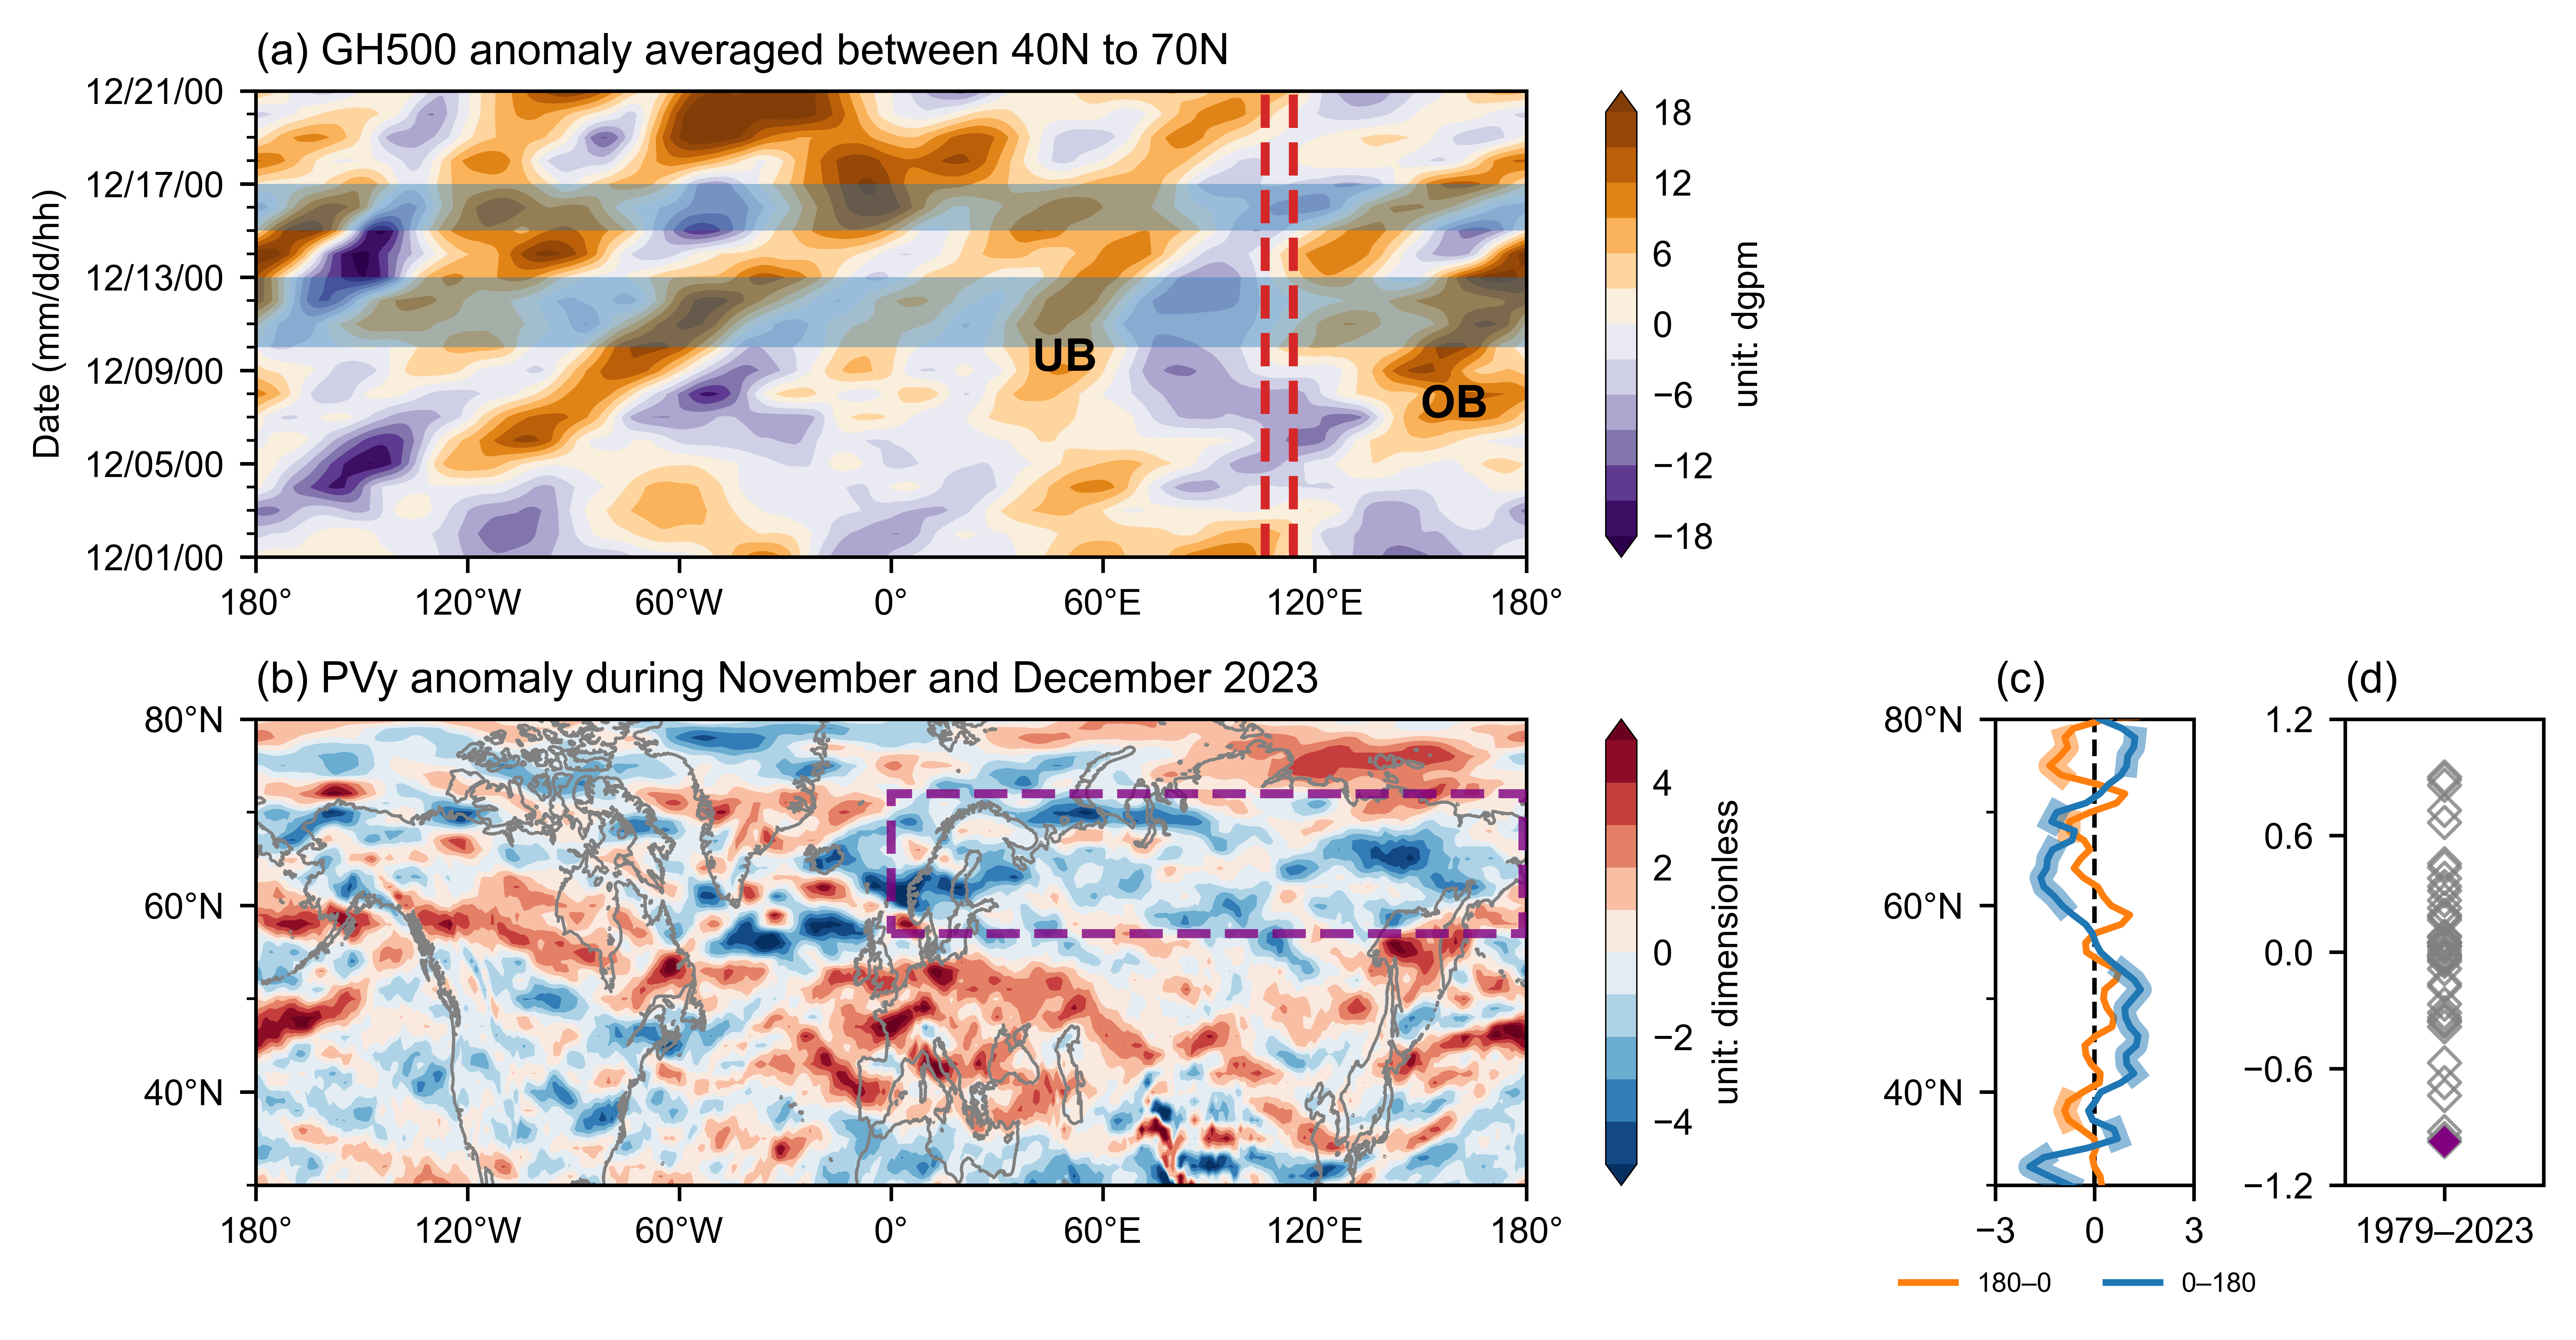

In [ ]:
'''
------------------------------------------------
Visualize the data
------------------------------------------------
'''


fig, axs = plt.subplots(2, 3, figsize=(8,4), dpi=1000, gridspec_kw={'width_ratios':[8,1,1]})


''' ---------------------------------------------- ax[0,0] ---------------------------------------------- '''
ax = axs[0,0]
weights = np.cos(np.deg2rad(Z500_ano_UTC00_2023['latitude']))
Z500_ano_40to70N = Z500_ano_UTC00_2023.loc[:,70:30,:].weighted(weights).mean('latitude')
new_longitude_values = np.linspace(360,720,360)
Z500_ano_40to70N_extend = xr.concat([Z500_ano_40to70N,Z500_ano_40to70N.assign_coords(longitude=new_longitude_values)], dim='longitude')
ax_Z500_ano = ax.contourf(Z500_ano_40to70N_extend['longitude'], Z500_ano_40to70N_extend['time'], Z500_ano_40to70N_extend/100,
             levels=np.linspace(-18,18,13), cmap=cmaps.MPL_PuOr_r, extend='both')

### Mark the location of blockings ###
ax.text(400, Z500_ano_40to70N_extend['time'].loc['2023-12-09'].values, 'UB', fontsize=10, fontweight='bold', color='black')
ax.text(510, Z500_ano_40to70N_extend['time'].loc['2023-12-07'].values, 'OB', fontsize=10, fontweight='bold', color='black')

### x-axis ###
dlon = 60
xticks = np.arange(0, 720.1, dlon)
ax.set_xticks(xticks) 
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_xlim(180,540)
ax.axvline(x=106+360, color='tab:red', ls='--', lw=2) 
ax.axvline(x=114+360, color='tab:red', ls='--', lw=2) 

### y-axis ###
ax.set_yticks(Z500_ano_40to70N_extend['time'][::4])
ax.set_ylim(Z500_ano_40to70N_extend['time'].loc['2023-12-01'], Z500_ano_40to70N_extend['time'].loc['2023-12-21'])
ax.yaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%H'))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylabel('Date (mm/dd/hh)')
ax.axhspan(Z500_ano_40to70N_extend['time'].loc['2023-12-10 00:00'].values, Z500_ano_40to70N_extend['time'].loc['2023-12-13 00:00'].values, 
           color='tab:blue', alpha=0.4, linewidth=0)
ax.axhspan(Z500_ano_40to70N_extend['time'].loc['2023-12-15 00:00'].values, Z500_ano_40to70N_extend['time'].loc['2023-12-17 00:00'].values, 
           color='tab:blue', alpha=0.4, linewidth=0)

### Colorbar ###
cb = fig.colorbar(ax_Z500_ano, ax=ax, orientation='vertical', spacing='proportional',
            drawedges=False, shrink=1, aspect=15)
cb.ax.tick_params(axis='both', length=0)
cb.outline.set_visible(True)
cb.set_label('unit: dgpm')
cb.outline.set_linewidth(0.3) 

ax.set_title('(a) GH500 anomaly averaged between 40N to 70N', loc='left')
''' ---------------------------------------------- ax[0,0] ---------------------------------------------- '''


''' ---------------------------------------------- ax[1,0] ---------------------------------------------- '''
ax = axs[1,0]
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

data_ccrs = ccrs.PlateCarree()
projection = ccrs.PlateCarree(central_longitude=0)
ax.axis('off')
ax = fig.add_subplot(2, 3, 4, projection=projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.7, edgecolor='gray') 
### Contour of dPV_dy_nondim_Ano_2023NovDec.mean('time') ###
var_contour, lon_cyclic = add_cyclic_point(dPV_dy_nondim_Ano_2023NovDec.mean('time').loc[90:0,:], coord=dPV_dy_nondim_Ano_2023NovDec.mean('time').loc[90:0,:]['longitude'])
ax_dPV_dy_ano = ax.contourf(lon_cyclic, dPV_dy_nondim_Ano_2023NovDec.mean('time').loc[90:0,:]['latitude'], var_contour,
                            levels=np.linspace(-5,5,11), cmap=cmaps.MPL_RdBu_r, extend='both', alpha=1, transform=data_ccrs)

### x-axis ###
dlon = 60
xticks = np.arange(-420, 420.1, dlon)
ax.set_xticks(xticks, crs=data_ccrs) 
ax.xaxis.set_major_formatter(LongitudeFormatter())  

### y-axis ###
yticks = [40,60,80]  
ax.set_yticks(yticks, crs=data_ccrs) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

### Set the extent of map ###
extent = [-180, 180, 30, 80] 
ax.set_extent(extent, crs=data_ccrs)  
ax.set_aspect('auto')

### Colorbar ###
cb = fig.colorbar(ax_dPV_dy_ano, ax=ax, orientation='vertical',spacing='proportional',
                  drawedges=False, shrink=1, aspect=15)
cb.ax.tick_params(axis='both', length=0)
cb.outline.set_visible(True)
cb.set_label('unit: dimensionless')
cb.outline.set_linewidth(0.3) 

### Region ###
PVy_region = patches.Rectangle((0, 57), 179, 15, edgecolor='purple', facecolor='none', transform=data_ccrs, ls='--', lw=2, alpha=0.8, zorder=7)
ax.add_patch(PVy_region)

ax.set_title('(b) PVy anomaly during November and December 2023', loc='left')
''' ---------------------------------------------- ax[1,0] ---------------------------------------------- '''


''' ---------------------------------------------- ax[1,1] ---------------------------------------------- '''
ax = axs[1,1]
line1, = ax.plot(dPV_dy_nondim_WEST_Ano_2023NovDec, dPV_dy_nondim_WEST_Ano_2023NovDec['latitude'],
        color='tab:orange', lw=1.5, label='180–0', zorder=5)
ax.plot(dPV_dy_nondim_WEST_Ano_2023NovDec.where((dPV_dy_nondim_WEST_StdAno_2023NovDec>=1)|(dPV_dy_nondim_WEST_StdAno_2023NovDec<=-1)), dPV_dy_nondim_WEST_Ano_2023NovDec['latitude'],
        color='tab:orange', alpha=0.5, lw=5, zorder=5)
line2, = ax.plot(dPV_dy_nondim_EAST_Ano_2023NovDec, dPV_dy_nondim_EAST_Ano_2023NovDec['latitude'],
        color='tab:blue', lw=1.5, label='0–180', zorder=5)
ax.plot(dPV_dy_nondim_EAST_Ano_2023NovDec.where((dPV_dy_nondim_EAST_StdAno_2023NovDec>=1)|(dPV_dy_nondim_EAST_StdAno_2023NovDec<=-1)), dPV_dy_nondim_EAST_Ano_2023NovDec['latitude'],
        color='tab:blue', alpha=0.5, lw=5, zorder=5)

### x-axis ###
ax.set_xticks(np.linspace(-3,3,3))
ax.set_xlim(-3,3)
ax.axvline(x=0, color='black', ls='--', lw=1)

### y-axis ###
ax.set_yticks(yticks)
ax.set_ylim(30,80)
ax.yaxis.set_major_formatter(LatitudeFormatter()) 
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.axhline(y=70, color='purple', ls='--', lw=2, alpha=0.8)
# ax.axhline(y=60, color='purple', ls='--', lw=2, alpha=0.8)

### Legend ###
legend = fig.legend(handles=[line1,line2], loc='lower center', ncol=2,  fontsize=6, bbox_to_anchor=(0.805,-0.025))
legend.get_frame().set_alpha(0)

# ax.grid(True, color='gray', ls='--', lw=0.25)
ax.set_title('(c)', loc='left')
''' ---------------------------------------------- ax[1,1] ---------------------------------------------- '''


''' ---------------------------------------------- ax[1,2] ---------------------------------------------- '''
ax = axs[1,2]
ax.scatter(np.ones_like(dPV_dy_nondim_region_Ano_1979to2023), dPV_dy_nondim_region_Ano_1979to2023, 
           facecolor='none', edgecolor='gray', marker='D', linewidth=0.8, s=25, alpha=0.8, zorder=5)
ax.scatter(1, dPV_dy_nondim_region_Ano_1979to2023.loc[2023], 
           facecolor='purple', edgecolor='none', marker='D', linewidth=0.8, s=25, alpha=1, zorder=7)

ax.set_xlim(0.5,1.5)
ax.set_xticks([1])
ax.set_xticklabels(['1979–2023'])
ax.set_xlim(0.8,1.2)
ax.set_yticks(np.linspace(-1.2,1.2,5)) 
ax.set_ylim(-1.2,1.2)
# ax.set_ylabel('PVy anomaly')
ax.set_title('(d)', loc='left')
''' ---------------------------------------------- ax[1,2] ---------------------------------------------- '''


''' ---------------------------------------------- ax[0,1],ax[0,2] ---------------------------------------------- '''
axs[0,1].axis('off')
axs[0,2].axis('off')
''' ---------------------------------------------- ax[0,1],ax[0,2] ---------------------------------------------- '''


plt.tight_layout()
plt.savefig(f'./figure-4.jpg',
            bbox_inches='tight')
plt.show()